We scanned *a lot* of teeth for the ZMK guys and gals.
With this notebook we prepare the tomographic datasets for display and analysis.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
from numcodecs import Blosc
from tqdm import notebook
import skimage.filters
import skimage.morphology
import skimage.segmentation
import scipy.ndimage

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# https://stackoverflow.com/a/62242245/323100
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set up figure defaults
# Display all images in b&w and with 'nearest' interpolation
plt.rc('image', cmap='gray', interpolation='nearest')
# Resize figures
plt.rcParams['figure.figsize'] = (16, 9)

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [7]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\ZMK-redo\Output\7d4687e


In [8]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'ZMK')
b0rkpath = False  # Change path to something wrong, so we can test the download feature
if b0rkpath:
    Root = 'SOMEWHERE WRONG'
print('We are loading all the data from %s' % Root)

We are loading all the data from S:\ZMK


In [10]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [11]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [12]:
# Look only for folders: https://stackoverflow.com/a/38216530
Data['Folder'] = glob.glob(os.path.join(Root, 'ToothBattallion', '*' + os.path.sep))

In [13]:
if len(Data):
    # Temporarily use a subset of the data
    # By setting a random state we always get the same subset, which is nice for the publication...
    Data = Data.sample(n=24, random_state=1796)
    Data.reset_index(drop=True, inplace=True)
    print('We are currently working with a subset of %s teeth' % len(Data))

We are currently working with a subset of 24 teeth


In [14]:
if not len(Data):
    # Our dataframe is empty.
    # We might be running on Binder, i.e. offer to download some sample data :)
    import requests
    # Inform user
    print('You are most probably running the notebook on binder and thus do not have access to the data files')
    print('We are downloading and unpacking two of them for you...')
    # Change root folder
    Root = 'data'
    os.makedirs(Root, exist_ok=True)
    # Download two files with the reconstructions of two teeth
    filelist = ['https://osf.io/7trgk/download', 'https://osf.io/fqm4x/download']
    ziplist = ['7.zip', '45.zip']   
    for c, file in enumerate(filelist):
        if os.path.exists(os.path.join(Root, ziplist[c])):
            print(os.path.join(Root, ziplist[c]), 'already downloaded')
        else:
            # Progress bar for download via https://stackoverflow.com/a/44920494/323100
            download = requests.get(file, stream=True)
            totalsize = int(download.headers["Content-Length"])
            chunksize = 1024 * 1024
            bars = int(totalsize / chunksize)
            with open(os.path.join(Root, ziplist[c]), "wb") as f:
                for chunk in notebook.tqdm(download.iter_content(chunk_size=chunksize),
                                           total=bars,
                                           unit="MB",
                                           desc='Downloading %s (%s GB)' % (ziplist[c],
                                                                            round(totalsize * 1e-9,1))):
                    f.write(chunk)
    # Unzip the files
    import zipfile
    ziplist = glob.glob(os.path.join(Root, '*.zip'))
    for downloaded_file in notebook.tqdm(ziplist,
                              total=len(ziplist),
                              desc='Unzipping %s files' % len(ziplist)):
        with zipfile.ZipFile(downloaded_file, 'r') as zip_file:
            for file in notebook.tqdm(iterable=zip_file.namelist(),
                                      desc=file,
                                      total=len(zip_file.namelist()),
                                      leave=False):
                if not os.path.exists(os.path.join(Root, file)):
                    zip_file.extract(member=file, path=Root)
    # Read in what we downloaded, now len(Data) should not be zero :)
    Data['Folder'] = glob.glob(os.path.join(Root, '*' + os.path.sep))

In [16]:
print('We work with %s tooth folders in %s' % (len(Data), Root))

We work with 24 tooth folders in S:\ZMK


In [19]:
# We could do it in a list comprehension, but then it fails if we're still scanning a tooth
# Data['LogFile'] = [sorted(glob.glob(os.path.join(f, '*.log')))[0] for f in Data['Folder']]
for c, row in Data.iterrows():
    try:
        Data.at[c, 'LogFile'] = sorted(glob.glob(os.path.join(row['Folder'], '*.log')))[0]
    except IndexError:
        print('No logfile found in %s, removing the folder temporarily' % row.Folder)
        Data.at[c, 'LogFile'] = 'scanning'
Data = Data[Data['LogFile'] != 'scanning']
Data.reset_index(drop=True, inplace=True)
print('We have %s tooth folders to work with' % (len(Data)))

We have 24 tooth folders to work with


In [20]:
Data['Sample'] = [os.path.splitext(os.path.basename(l))[0] for l in Data['LogFile']]

In [21]:
# Proper sorting *with* leading zeros :)
Data.sort_values(by=['Sample'], inplace=True)

In [22]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f,
                                                         'rec',
                                                         '*rec*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [23]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s tooth folders with reconstructions' % (len(Data)))

We have 24 tooth folders with reconstructions


In [24]:
print('In total, we have',
      Data['Number of reconstructions'].sum(),
      'reconstructions over all the 104 datasets')

In total, we have 64775 reconstructions over all the 104 datasets


In [25]:
print('On average, each tooth has about',
      int(round(Data['Number of reconstructions'].mean())),
      'reconstructions.')

On average, each tooth has about 2699 reconstructions.


In [26]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [27]:
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [28]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
if len(Data['Voxelsize'].round(2).unique()) > 1:
    print('We scanned the teeth with %s different voxel sizes' % len(Data['Voxelsize'].round(2).unique()))
    for vs in sorted(Data['Voxelsize'].round(2).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], 2):
                print(row.Sample, end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s.' % Data['Voxelsize'].unique()[0])

We scanned all datasets with equal voxel size, namely 9.999986.


In [29]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [30]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                stacks = int(line.split('=')[1])
    return(stacks)

In [31]:
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

In [32]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1]
    return(time)

In [33]:
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]

In [34]:
def get_numproj(logfile):
    """How many projections did we record?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number' in line and 'Files' in line:
                numproj = int(line.split('=')[1])
    return(numproj)

In [35]:
Data['Number of Projections'] = [get_numproj(log) for log in Data['LogFile']]

In [36]:
Data.head()

Folder                                 LogFile  \
0   S:\ZMK\ToothBattallion\5\   S:\ZMK\ToothBattallion\5\Tooth005.log   
1  S:\ZMK\ToothBattallion\11\  S:\ZMK\ToothBattallion\11\Tooth011.log   
2  S:\ZMK\ToothBattallion\14\  S:\ZMK\ToothBattallion\14\Tooth014.log   
3  S:\ZMK\ToothBattallion\15\  S:\ZMK\ToothBattallion\15\Tooth015.log   
4  S:\ZMK\ToothBattallion\20\  S:\ZMK\ToothBattallion\20\Tooth020.log   

     Sample                                    Reconstructions  \
0  Tooth005  [S:\ZMK\ToothBattallion\5\rec\Tooth005_rec0000...   
1  Tooth011  [S:\ZMK\ToothBattallion\11\rec\Tooth011_rec000...   
2  Tooth014  [S:\ZMK\ToothBattallion\14\rec\Tooth014_rec000...   
3  Tooth015  [S:\ZMK\ToothBattallion\15\rec\Tooth015_rec000...   
4  Tooth020  [S:\ZMK\ToothBattallion\20\rec\Tooth020_rec000...   

   Number of reconstructions  Voxelsize  Stacks     Scan time  \
0                       2772   9.999986       5  0h:40m:31s\n   
1                       2616   9.999986       5  0h:40m:34s\n   
2                       2581   9.999986       5  0h:40m:28s\n   
3                       2651   9.999986       5  0h:40m:32s\n   
4                       2703   9.999986       5  0h:40m:33s\n   

   Number of Projections  
0                    482  
1                    482  
2                    482  
3                    482  
4                    482

In [37]:
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]

In [38]:
if len(Data['Grayvalue'].unique()) > 1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c, row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(row.Sample, end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed all datasets with equal maximum gray value, namely 0.18.


In [39]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, c, row100)) for pip in Data['PreviewImagePath']]

In [40]:
# plt.rcParams['figure.figsize'] = (10, 20)

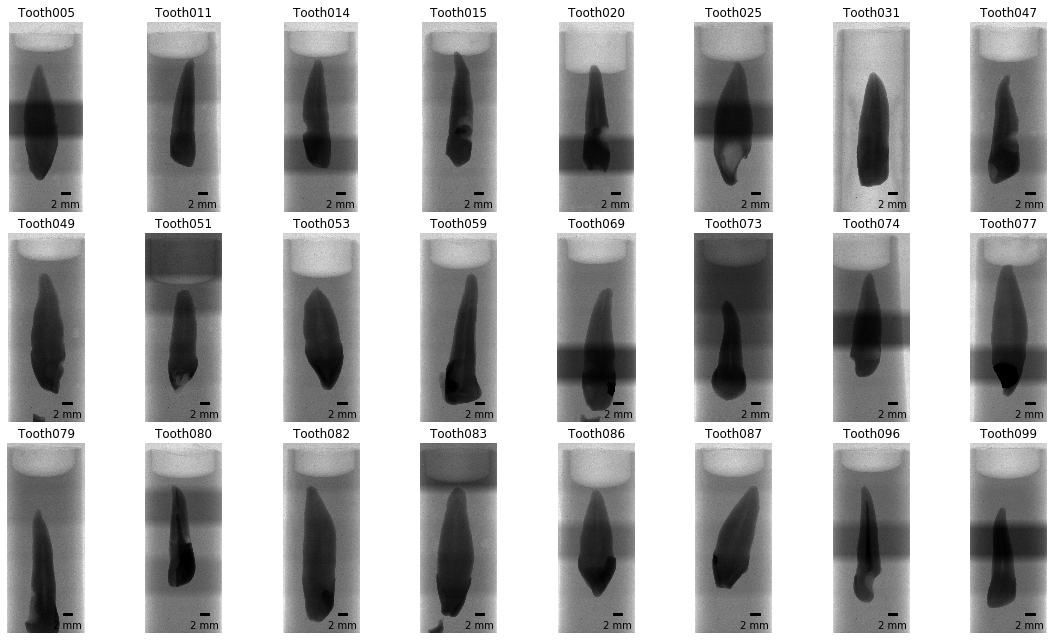

In [41]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(OutPutDir, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [42]:
# plt.rcParams['figure.figsize'] = (16, 9)

In [44]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%3s/%3s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root):]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], 'rec', '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [45]:
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [46]:
# Load the reconstructions as zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [47]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [48]:
def cropper(image,
            despeckle=True,
            verbose=False,
            threshold=50):
    '''Crop array to biggest item in it'''
    dimensions = len(image.shape)
    if verbose:
        print('Cropping %s-dimensional image' % dimensions)
    # Threshold
    thresholded = image > threshold
    if despeckle:
        if verbose:
            print('Removing small objects')
        despeckled = skimage.util.apply_parallel(skimage.morphology.remove_small_objects,
                                                 thresholded,
                                                 extra_keywords={'min_size': 10**dimensions},
                                                 chunks=[15,15,15])
    # Find biggest object
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html
    if verbose:
        print('Finding objects')
    if despeckle:
        cropdimensions = scipy.ndimage.find_objects(despeckled)[0]
    else:
        cropdimensions = scipy.ndimage.find_objects(thresholded)[0]
    if verbose:
        print('Cutting the image down to')
        for c, cd in enumerate(cropdimensions):
            print('\t- %s: %s' % (c, cd))
        if dimensions > 2:
            # Calculate cardinal direction MIPs
            MIPs = [image.max(axis=d) for d, direction in notebook.tqdm(enumerate(directions),
                                                                                  desc='Calculating MIPs',
                                                                                  total=len(directions))]
            for d, direction in enumerate(directions):
                plt.subplot(1, dimensions, d + 1)
                plt.imshow(MIPs[d], alpha=0.618)
                plt.imshow(dask.array.ma.masked_less(MIPs[d]>threshold, 1),
                           alpha=0.309,
                           cmap='viridis_r')
                if d == 0:
                    plt.axhline(cropdimensions[1].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[1].start)
                    plt.axhline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[1].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)
                elif d == 1:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[2].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[2].start)
                    plt.axvline(cropdimensions[2].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[2].stop)                    
                elif d == 2:
                    plt.axhline(cropdimensions[0].start,
                                c=seaborn.color_palette()[0],
                                label=cropdimensions[0].start)
                    plt.axhline(cropdimensions[0].stop,
                                c=seaborn.color_palette()[1],
                                label=cropdimensions[0].stop)
                    plt.axvline(cropdimensions[1].start,
                                c=seaborn.color_palette()[2],
                                label=cropdimensions[1].start)
                    plt.axvline(cropdimensions[1].stop,
                                c=seaborn.color_palette()[3],
                                label=cropdimensions[1].stop)                                        
                plt.title('%s MIP' % direction)
                plt.legend(loc='lower right')
        else:
            plt.subplot(121)
            plt.imshow(image, alpha=0.618)
            plt.imshow(dask.array.ma.masked_less(thresholded, 1), alpha=0.618, cmap='viridis_r')
            plt.axhline(cropdimensions[0].start, c=seaborn.color_palette()[0], label=cropdimensions[0].start)
            plt.axhline(cropdimensions[0].stop, c=seaborn.color_palette()[1], label=cropdimensions[0].stop)
            plt.axvline(cropdimensions[1].start, c=seaborn.color_palette()[2], label=cropdimensions[1].start)
            plt.axvline(cropdimensions[1].stop, c=seaborn.color_palette()[3], label=cropdimensions[1].stop)
            plt.title('Original image with thresholded overlay')
            plt.legend(loc='lower right')
            plt.subplot(122)
            plt.imshow(image[cropdimensions])
            plt.title('Output')
        plt.show()
    if verbose:
        print('Cropped image from %s to %s' % (image.shape, image[cropdimensions].shape))
        print(cropdimensions)
    return(image[cropdimensions])

In [49]:
# # Test cropping function
# img = Reconstructions[3][1900:]
# Cropped = cropper(img, verbose=True, despeckle=True, threshold=55)
# for c, direction in enumerate(directions):
#     plt.subplot(1,3,c+1)    
#     if 'Axial' in direction:
#         plt.imshow(Cropped[Cropped.shape[0] // 2])
#     if 'Sagittal' in direction:
#         plt.imshow(Cropped[:, Cropped.shape[1] // 2, :])
#     if 'Coronal' in direction:
#         plt.imshow(Cropped[:, :, Cropped.shape[2] // 2])

In [50]:
# Crop the reconstructions and save them out as .zarr files, too
Data['OutputNameRecCrop'] = [os.path.join(f, sample + '_rec_crop.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving cropped teeth to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRecCrop']):
        print('%3s/%3s: Saving to %s' % (c + 1,
                                         len(Data),
                                         row['OutputNameRecCrop'][len(Root):]))
        # Calculate crop with our function and directly write to ZARR file
        cropper(Reconstructions[c],
                verbose=True,
                despeckle=True).to_zarr(row['OutputNameRecCrop'],
                                        overwrite=True,
                                        compressor=Blosc(cname='zstd',
                                                         clevel=3,
                                                         shuffle=Blosc.BITSHUFFLE))        

In [51]:
# Load the cropped zarr arrays as reconstructions
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRecCrop']]

In [52]:
# Save out cropped rec slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out cropped recs',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'rec_crop'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(Reconstructions[c]),
                                total=len(Reconstructions[c]),
                                desc=row.Sample,
                                leave=False):
        filename = os.path.join(row.Folder,
                                'rec_crop', str(row.Sample) + '_rec_crop_%08d.png' % d)
        if not os.path.exists(filename):
            imageio.imsave(filename, rec)

In [53]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Reconstructions[c].shape[0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Reconstructions[c].shape[1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Reconstructions[c].shape[2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

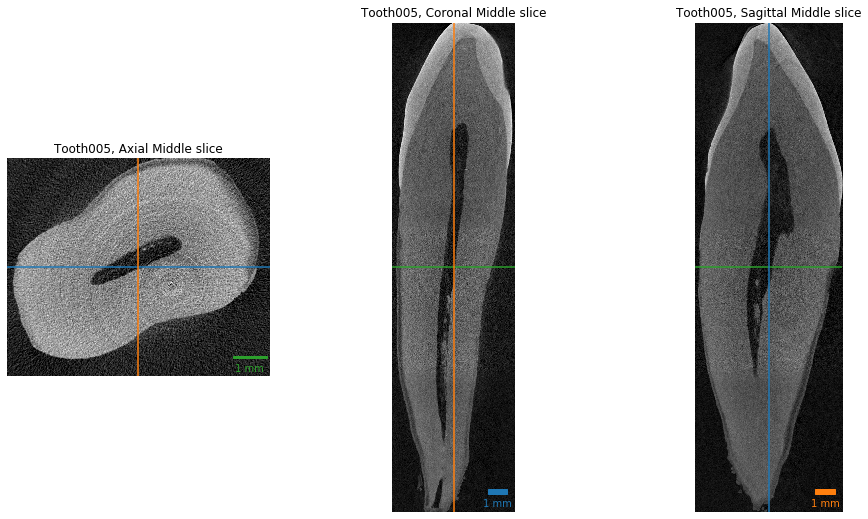

In [54]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MiddleSlices.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction])
            if d == 0:
                plt.axhline(Reconstructions[c].shape[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(Reconstructions[c].shape[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(Reconstructions[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Reconstructions[c].shape[1] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
            else:
                plt.axhline(Reconstructions[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Reconstructions[c].shape[2] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' Middle slice'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [55]:
# for c, row in Data.iterrows():
#     print(c, row.Sample, Reconstructions[c].shape)

In [56]:
# Read or calculate the directional MIPs of the cropped reconstructions
# Put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Data)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            try:
                # Generate MIP
                Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            except ZeroDivisionError:
                print('Something does not work for %s, copying uncropped MIP' % row['Sample'])
                Data.at[c, 'MIP_' + direction] = Data.at[c, 'MIP_' + direction]
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

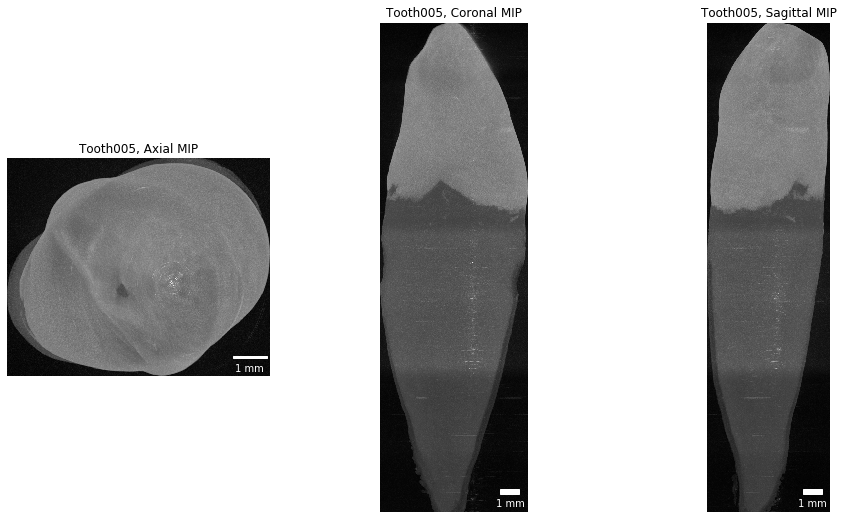

In [57]:
# Show MIPs
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving cropped MIP overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.MIPs.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

To help with the characterization of the bottom part of the tooth it is necessary to have coronal/sagittal slices of the lowest ~3mm. 
Lets thus extract these slices and write them to disk.

In [58]:
# How many slices are 3.5mm?
Data['BottomSlices'] = [int(round(3500 / vs)) for vs in Data['Voxelsize']]

In [59]:
# Crop and save out bottom of tooth
Data['OutputNameRecApex'] = [os.path.join(f, sample + '_apex_rec.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving apex to .zarr file',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRecApex']):
        print('%3s/%3s: Saving to %s' % (c + 1,
                                         len(Data),
                                         row['OutputNameRecApex']))
        
        # Save out the bottom part of the tooth after cropping it to its minimal size       
        cropper(Reconstructions[c][-row.BottomSlices:],
                verbose=False,
                threshold=50).to_zarr(row['OutputNameRecApex'],
                                      overwrite=True,
                                      compressor=Blosc(cname='zstd',
                                                       clevel=3,
                                                       shuffle=Blosc.BITSHUFFLE))

In [60]:
# Load the bottom zarr arrays
Apexes = [dask.array.from_zarr(file) for file in Data['OutputNameRecApex']]

In [61]:
# Reslice the bottom part and write it out
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving resliced bottom part',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_reslice'),
                exist_ok=True)
    # load the full dataset into memory if empty, otherwise just map it
    # Otherwise the reslicing takes *ages*
    if os.listdir(os.path.join(row.Folder,
                               'apex_reslice')):
        apex = Apexes[c]
    else:
        apex = Apexes[c].compute()
    for d in notebook.tqdm(range(Apexes[c].shape[-1]),
                           desc=row.Sample,
                           leave=False):
        filename = os.path.join(row.Folder,
                                'apex_reslice',
                                str(row.Sample) + '_rec_apex_sagittal_%04d.png' % d)
        if not os.path.exists(filename):
            imageio.imsave(filename, apex[:, :, d])

In [62]:
# Read or calculate the middle slices of the bottom part, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_Apex_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Apex.Middle.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_Apex_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_Apex_' + direction] = Apexes[c][Apexes[c].shape[0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_Apex_' + direction] = Apexes[c][:, Apexes[c].shape[1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_Apex_' + direction] = Apexes[c][:, :, Apexes[c].shape[2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

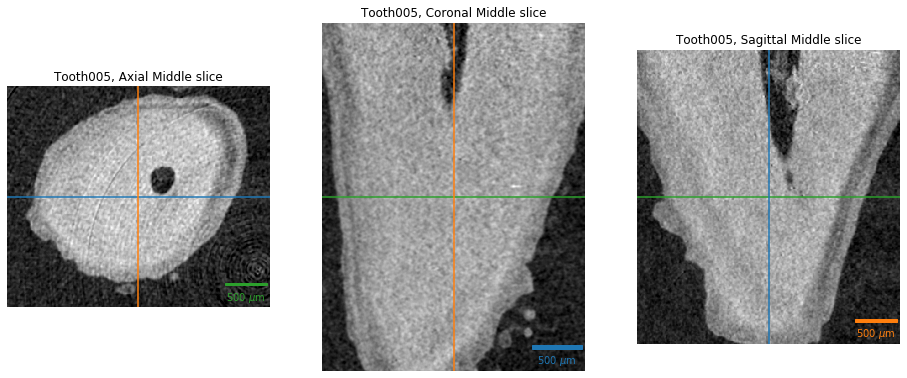

In [63]:
# Show middle slices of the apex
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.Apex.MiddleSlices.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_Apex_' + direction])
            if d == 0:
                plt.axhline(Apexes[c].shape[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(Apexes[c].shape[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(Apexes[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Apexes[c].shape[1] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
            else:
                plt.axhline(Apexes[c].shape[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(Apexes[c].shape[2] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' Middle slice'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [64]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Apex_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(row['Folder'], '%s.Apex.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_Apex_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_Apex_' + direction] = Apexes[c].max(axis=d)
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_Apex_' + direction].astype('uint8'))

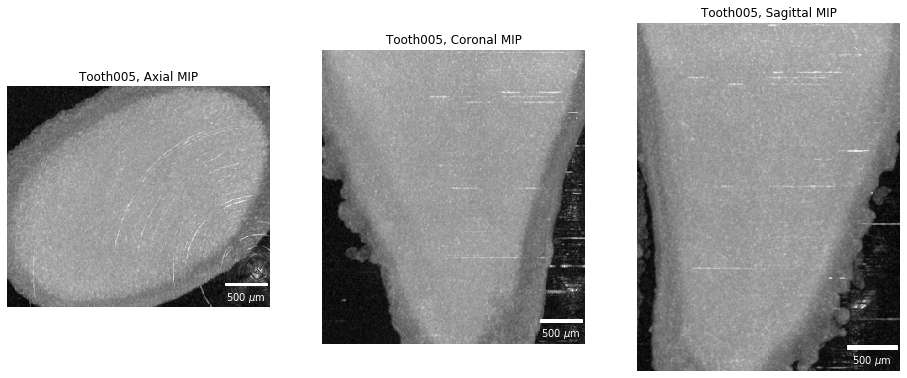

In [65]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving bottom MIP overview', total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.Apex.MIPs.png')
    if not os.path.exists(outfilepath):
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_Apex_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (row['Sample'],
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [66]:
# for file in Data['OutputNameRecCrop']:
#     print(file)
#     dask.array.from_zarr(file)

In [67]:
def get_partialpart(reconstruction, slicenumber, what='min', numberofslicesaround=50, verbose=False):
    '''
    Function to get a small part around the selected slice number.
    We select the minima to (potentially) show any accessory canals nicely
    '''
    if what == 'min':
        part = numpy.min(reconstruction[slicenumber - numberofslicesaround // 2:
                                        slicenumber + numberofslicesaround // 2],
                         axis=0)
    if what == 'max':
        part = numpy.max(reconstruction[slicenumber - numberofslicesaround // 2:
                                        slicenumber + numberofslicesaround // 2],
                         axis=0)
    if what == 'mean':
        part = numpy.mean(reconstruction[slicenumber - numberofslicesaround // 2:
                                         slicenumber + numberofslicesaround // 2],
                          axis=0)
    if not what:
        part = reconstruction[slicenumber]
    if verbose:
        plt.imshow(part)
    return(part)

dask.array<amin-aggregate, shape=(708, 647), dtype=uint8, chunksize=(708, 647), chunktype=numpy.ndarray>

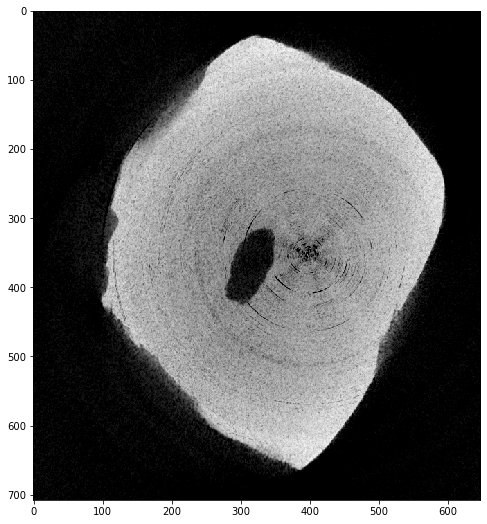

In [68]:
get_partialpart(Reconstructions[2], 999, what='min', verbose=True, numberofslicesaround=250)

dask.array<amax-aggregate, shape=(708, 647), dtype=uint8, chunksize=(708, 647), chunktype=numpy.ndarray>

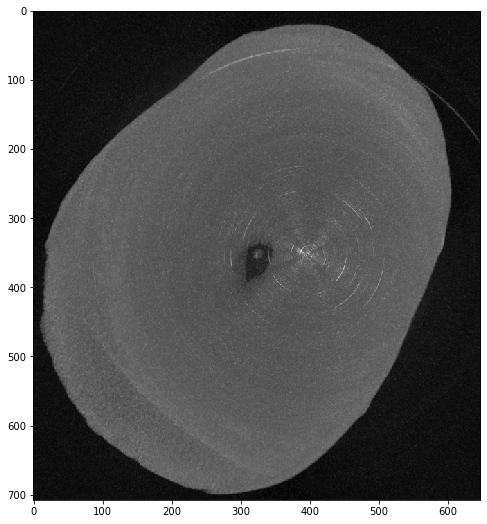

In [69]:
get_partialpart(Reconstructions[2], 999, what='max', verbose=True, numberofslicesaround=250)

dask.array<mean_agg-aggregate, shape=(708, 647), dtype=float64, chunksize=(708, 647), chunktype=numpy.ndarray>

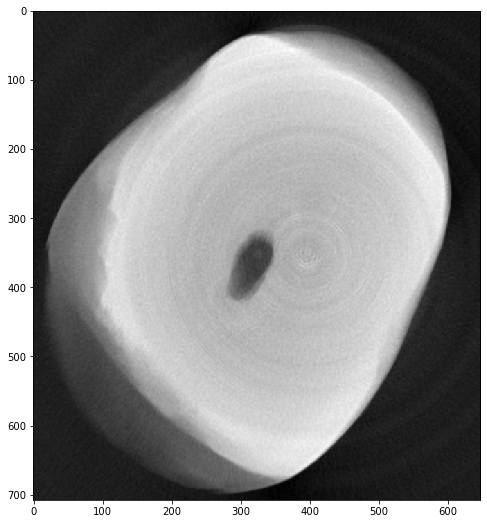

In [70]:
get_partialpart(Reconstructions[2], 999, what='mean', verbose=True, numberofslicesaround=250)

dask.array<getitem, shape=(708, 647), dtype=uint8, chunksize=(708, 647), chunktype=numpy.ndarray>

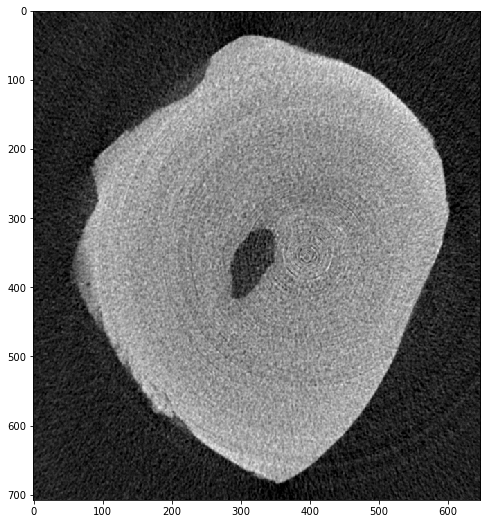

In [71]:
get_partialpart(Reconstructions[2], 999, what=None, verbose=True, numberofslicesaround=250)

In [72]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get the border of enamel/dentin.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=0.025)
    minima = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS')
        plt.axvline(minima, c='r', label='Border')
        plt.legend()
    return(minima, smoothed)

In [73]:
def splitter(whichone, top=0, bottom=50, curve=True, showregion=True, saveslices=True, verbose=False):
    '''
    According to the discussion on July 6 with Thomas & Andrea, the characterization of the pulpa is done at three levels.
    The start of the levels is at the border enamel/dentin.
    With a bit of filtering of the gray values of the MIPs along the tooth we find this border and then return three images in this region.
    We save the figure and return the four images.
    '''
    # First we need to detect the border.
    # We do this by smoothing the gray value along the tooth, calculating the difference along the axis and taking its minimum
    # This should be the border between enamel/dentin
    grayvalues = Data['MIP_Sagittal'][whichone].max(axis=1)
    if top < 1:
        # If we don't set it manually, calculate the border
        top, smoothed = get_minimum(grayvalues, verbose)
    else:
        smoothed = numpy.zeros_like(grayvalues)
    # Since we don't want the *very* bottom, we 'fake' slices extraction by generating the range,
    # splitting it in three,
    # selecting the start of each split as slices and
    # add a slice not at the very $bottom
    try:
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    except IndexError:
        print('Something went wrong with the slice calculation')
        top = 500
        curve = False
        slices = range(top, Reconstructions[whichone].shape[0])
        split = numpy.array_split(slices, 3)
        slices = [s[0] for s in split]
        slices.append(Reconstructions[whichone].shape[0] - bottom)
    if verbose:
        print('The scan has %s slices' % Reconstructions[whichone].shape[0])
        print('We found the enamel/dentin border at slice %s' % top)
        print('We split the distance from slice', end=' ')
        print('%s to %s in three parts (e.g. %s//3)' % (top,
                                                        Reconstructions[whichone].shape[0],
                                                        Reconstructions[whichone].shape[0] - top))
        print('We are returning slice', end=' ')
        for i in slices[:-1]:
            print(i, end=', ')
        print('and %s for the pulpa characterization' % slices[-1])
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 4)
    fig_mip_s = fig.add_subplot(gs[:, 0])
    plt.imshow(Data['MIP_Sagittal'][whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Sagittal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_s.set_title('Sagittal MIP\nSlices and grey value profile')
    fig_mip_c = fig.add_subplot(gs[:, 1])
    plt.imshow(Data['MIP_Coronal'][whichone])
    if curve:
        plt.plot(grayvalues / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data['MIP_Sagittal'][whichone].shape[0]),
                 alpha=0.618)
        plt.plot(smoothed / 2**8 * Data['MIP_Coronal'][whichone].shape[1],
                 range(Data['MIP_Coronal'][whichone].shape[0]),
                 alpha=0.618)
    for i in slices:
        plt.axhline(i, c='r')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    fig_mip_c.set_title('Coronal MIP\nSlices and grey value profile')
    for i in range(4):
        if i < 2:
            fig_slc = fig.add_subplot(gs[0, i + 2])
        else:
            fig_slc = fig.add_subplot(gs[1, i])
        if showregion:
            nsa = 40
            plt.imshow(get_partialpart(Reconstructions[whichone],
                                       slices[i],
                                       numberofslicesaround=nsa))
            fig_slc.set_title('Minima of %s slices around slice %s' % (nsa, slices[i]))
        else:
            plt.imshow(Reconstructions[whichone][slices[i]])
            fig_slc.set_title('Slice %s' % slices[i])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.axis('off')
    if verbose:
        print('Saving figure to %s' % os.path.join(Data.Folder[whichone],
                                                   Data.Sample[whichone] + 'ExtractedSlices.png'))
    plt.suptitle(Data.Sample[whichone])
    plt.savefig(os.path.join(Data.Folder[whichone],
                             Data.Sample[whichone] + '.ExtractedSlices.png'))
    plt.show()
    if saveslices:
        # Save out the slices if requested
        for slc in slices:
            imageio.imsave(os.path.join(Data.Folder[whichone],
                                        Data.Sample[whichone] + '.ExtractedSlice.%04d.png' % slc),
                           Reconstructions[whichone][slc])
    return(Reconstructions[whichone][slices])

  1/ 24: Detecting enamel/dentin border for Tooth005


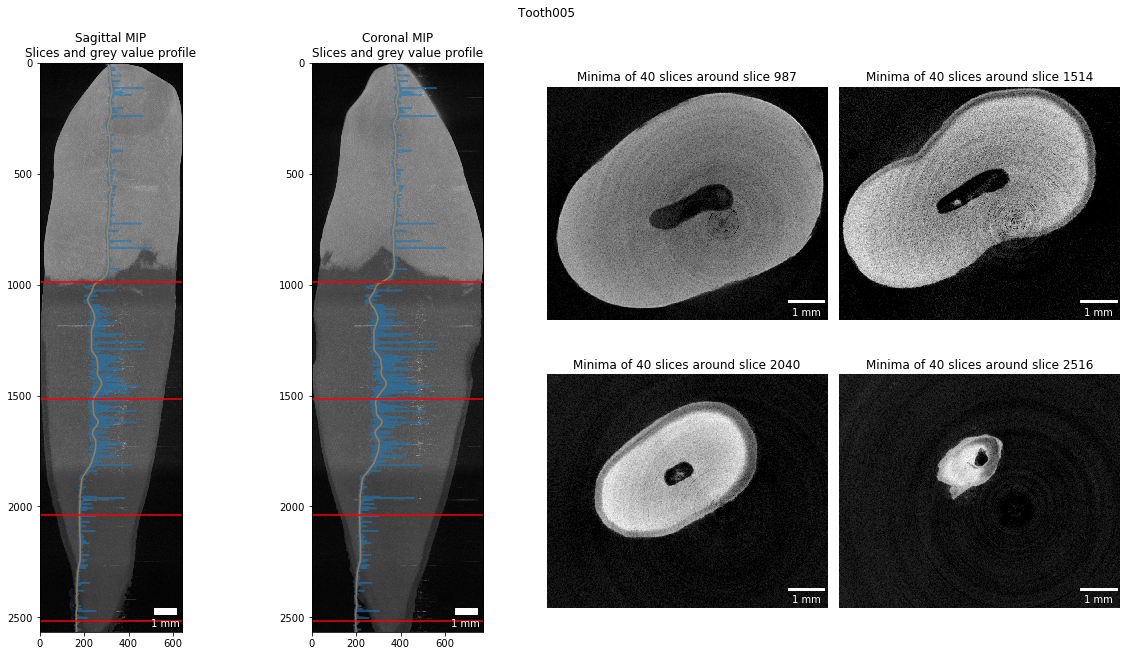

In [74]:
for c, row in Data.iterrows():
    if not os.path.exists(os.path.join(row.Folder, row.Sample + '.ExtractedSlices.png')):
        print('%3s/%3s: Detecting enamel/dentin border for %s' % (c + 1, len(Data), row.Sample))
        splitter(c)

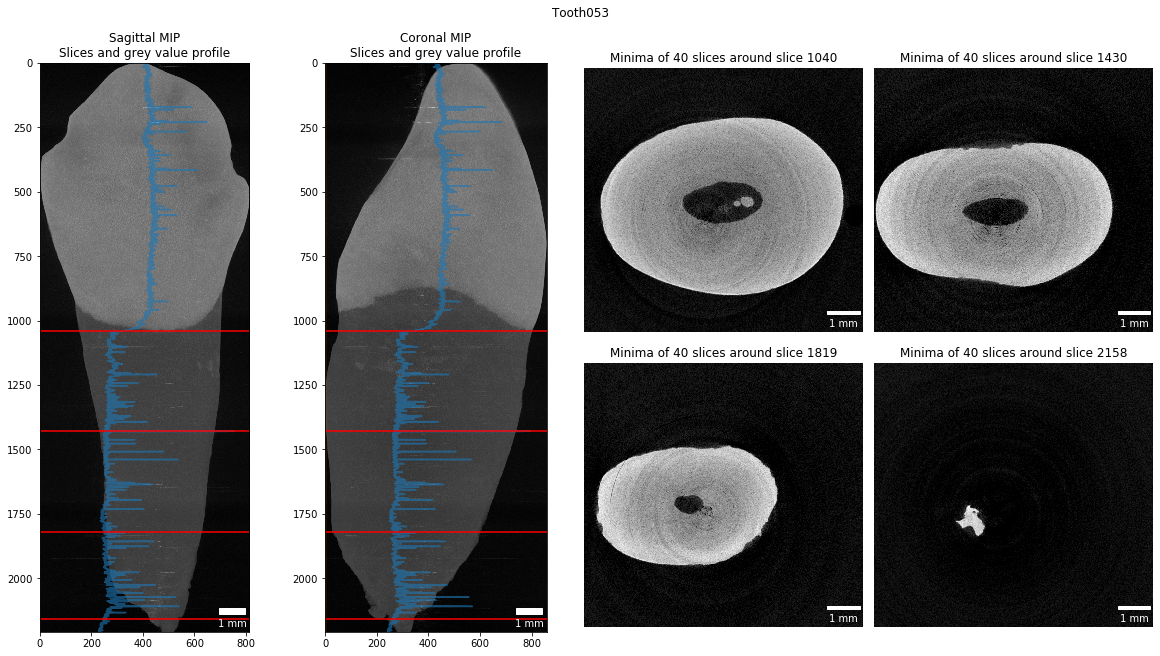

In [75]:
# For some samples the EDB detection doesn't work automatically
# One can do it by setting the 'top' variable
_ = splitter(10, top=1040)

In [76]:
def pulponator(image, verbose=False):
    '''Function to extract the pulpa from the tooth'''
    # Load image into memory (thresholding et al. does not work on Dask array)
    # https://github.com/dask/dask-image/issues/100
    image = image.compute()
    # Very crudely threshold the tooth from the background
    thresholded = image > skimage.filters.threshold_otsu(image)
    # The thresholded tooth is not the only feature in the image
    # If we remove the border on the inverted image, we get the stuff that is *not* connected to the border
    stuffinside = skimage.segmentation.clear_border(thresholded == False)
    # Let's remove some speckles (stuff larger than 16 px is left)
    # These are small speckles left over from the thresholding
    speckleless = skimage.morphology.remove_small_objects(stuffinside, min_size=8**2)
    # Now close holes in the pulpa region
    pulpa = skimage.morphology.remove_small_holes(speckleless, area_threshold=10**2)
    if verbose:
        plt.subplot(141)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Input image')
        plt.subplot(142)
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(thresholded, 0), cmap='viridis_r')
        plt.title('Thresholded')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(stuffinside, 0), cmap='viridis_r')
        plt.title('Uncleaned pulpa')
        plt.axis('off')
        plt.subplot(144)
        plt.axis('off')
        plt.imshow(image)
        plt.imshow(numpy.ma.masked_equal(pulpa, 0), cmap='viridis_r')
        plt.title('Cleaned pulpa over original')
        plt.axis('off')
        plt.show()
    return(pulpa)

In [77]:
# rec = Reconstructions[99][666]
# _=pulponator(rec, verbose=True)

In [78]:
# Extract pulpa from the *full* teeth
Data['OutputNamePulpa'] = [os.path.join(f, sample + '_pulpa.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting pulpa, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNamePulpa']):
        print('%3s/%3s: Extracting pulpa and saving to %s' % (c + 1,
                                                              len(Data),
                                                              row['OutputNamePulpa'][len(Root):]))
        Pulpa = [pulponator(rec) for rec in Reconstructions[c]]
        Pulpa = dask.array.stack(Pulpa[:])
        Pulpa.to_zarr(row['OutputNamePulpa'],
                      overwrite=True,
                      compressor=Blosc(cname='zstd',
                                       clevel=3,
                                       shuffle=Blosc.BITSHUFFLE))

In [79]:
# Load the pulpa zarr arrays
Pulpas = [dask.array.from_zarr(file) for file in Data['OutputNamePulpa']]

In [81]:
# Save out the pulpa slices
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out pulpa slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'pulpa'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(Pulpas[c]),
                                desc=row.Sample,
                                total=len(Pulpas[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'pulpa', str(row.Sample) + '_pulpa_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8') * 255)

In [82]:
# Extract pulpa from the *apex* of the teeth
Data['OutputNameApexPulpa'] = [os.path.join(f, sample + '_apex_pulpa.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting pulpa, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameApexPulpa']):
        print('%3s/%3s: Extracting pulpa and saving to %s' % (c + 1,
                                                              len(Data),
                                                              row['OutputNameApexPulpa'][len(Root):]))
        Pulpa = [pulponator(rec) for rec in Apexes[c]]
        Pulpa = dask.array.stack(Pulpa[:])
        Pulpa.to_zarr(row['OutputNameApexPulpa'],
                      overwrite=True,
                      compressor=Blosc(cname='zstd',
                                       clevel=3,
                                       shuffle=Blosc.BITSHUFFLE))

In [83]:
# Load the pulpa zarr arrays
ApexPulpas = [dask.array.from_zarr(file) for file in Data['OutputNameApexPulpa']]

In [84]:
# Save out the pulpa slices of the apexes
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out pulpa slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_pulpa'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(ApexPulpas[c]),
                                desc=row.Sample,
                                total=len(ApexPulpas[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'apex_pulpa', str(row.Sample) + '_pulpa_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8') * 255)

In [85]:
# EDT of *apex* of pulpas
Data['OutputNameEDT'] = [os.path.join(f, sample + '_apex_edt.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Extracting EDT of apex, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameEDT']):
        print('%3s/%3s: Calculating EDT and saving to %s' % (c + 1,
                                                              len(Data),
                                                              row['OutputNameEDT'][len(Root):]))
        EDT = scipy.ndimage.morphology.distance_transform_edt(ApexPulpas[c])
        EDT = dask.array.stack(EDT[:])
        EDT.to_zarr(row['OutputNameEDT'],
                    overwrite=True,
                    compressor=Blosc(cname='zstd',
                                     clevel=3,
                                     shuffle=Blosc.BITSHUFFLE))

In [86]:
# Load the EDT zarr arrays
EDTs = [dask.array.from_zarr(file) for file in Data['OutputNameEDT']]

In [87]:
# Save out the EDT slices
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out EDT slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_edt'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(EDTs[c]),
                                desc=row.Sample,
                                total=len(EDTs[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'apex_edt', str(row.Sample) + '_edt_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8'))

In [88]:
# Skeletonization of only the apex of the pulpas
Data['OutputNameSkeleton'] = [os.path.join(f, sample + '_apex_skeleton.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Skeletonization of apex, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameSkeleton']):
        print('%3s/%3s: Skeletonizing apex and saving to %s' % (c + 1,
                                                                len(Data),
                                                                row['OutputNameSkeleton'][len(Root):]))
        Skeleton = skimage.morphology.skeletonize_3d(ApexPulpas[c].astype('bool').compute())
        Skeleton = dask.array.stack(Skeleton[:].astype('bool'))
        Skeleton.to_zarr(row['OutputNameSkeleton'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd',
                                          clevel=3,
                                          shuffle=Blosc.BITSHUFFLE))

In [89]:
# Load the pupla zarr arrays
Skeletons = [dask.array.from_zarr(file) for file in Data['OutputNameSkeleton']]

In [90]:
# Merge EDT and skeleton, so we have the distance on the skeleton
Data['OutputNameSkelDist'] = [os.path.join(f, sample + '_apex_skeldist.zarr') for f, sample in zip(Data.Folder, Data.Sample)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Merging skel & EDT, saving to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameSkelDist']):
        print('%3s/%3s: Merging skeleton and EDT and saving to %s' % (c + 1,
                                                                      len(Data),
                                                                      row['OutputNameSkelDist'][len(Root):]))
        
        dask.array.multiply(EDTs[c], Skeletons[c]).to_zarr(row['OutputNameSkelDist'],
                                                           overwrite=True,
                                                           compressor=Blosc(cname='zstd',
                                                                            clevel=3,
                                                                            shuffle=Blosc.BITSHUFFLE))

In [91]:
# Load the skeldist zarr arrays
SkelDists = [dask.array.from_zarr(file) for file in Data['OutputNameSkelDist']]

In [92]:
# Save out the SkelDist slices
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out SkelDist slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_skeldist'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(SkelDists[c]),
                                desc=row.Sample,
                                total=len(SkelDists[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'apex_skeldist', str(row.Sample) + '_skeldist_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8'))

Tooth014


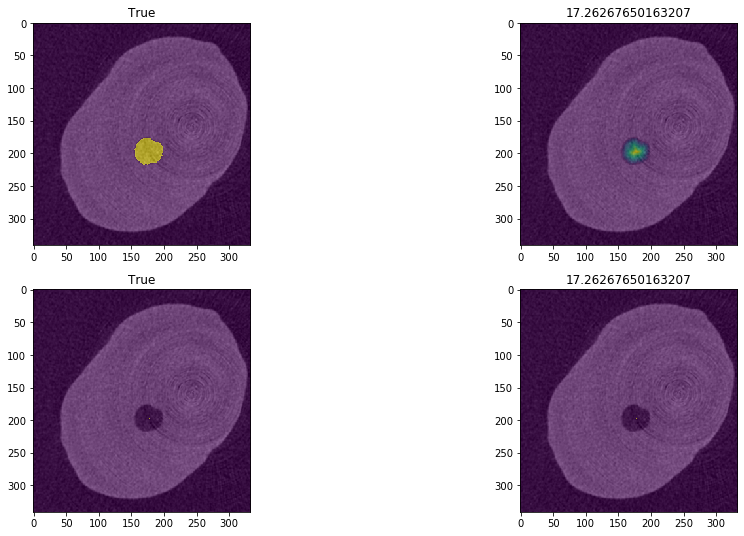

In [93]:
# Select one sample and slice to show what we did
whichone = 2
whichslice = 111
print(Data['Sample'][whichone])
plt.subplot(221)
plt.imshow(Apexes[whichone][whichslice])
plt.imshow(ApexPulpas[whichone][whichslice], alpha=0.618, cmap='viridis')
plt.title(ApexPulpas[whichone][whichslice].max().compute())
plt.subplot(222)
plt.imshow(Apexes[whichone][whichslice])
plt.imshow(EDTs[whichone][whichslice], alpha=0.618, cmap='viridis')
plt.title(EDTs[whichone][whichslice].max().compute())
plt.subplot(223)
plt.imshow(Apexes[whichone][whichslice])
plt.imshow(Skeletons[whichone][whichslice], alpha=0.618, cmap='viridis')
plt.title(Skeletons[whichone][whichslice].max().compute())
plt.subplot(224)
plt.imshow(Apexes[whichone][whichslice])
plt.imshow(SkelDists[whichone][whichslice], alpha=0.618, cmap='viridis')
plt.title(SkelDists[whichone][whichslice].max().compute())
plt.show()

In [95]:
import itkwidgets
from itkwidgets import view

In [96]:
# 3D view of bottom part
view(Reconstructions[whichone][-Data['BottomSlices'][whichone]:].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [97]:
# 3D view of SkeletonDistance
view(SkelDists[whichone].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [98]:
# Overlay teeth and EDT of pulpa
TeethPulpa = numpy.maximum(EDTs[whichone] * 255,
                           Apexes[whichone]).astype('uint8')

In [99]:
view(TeethPulpa)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

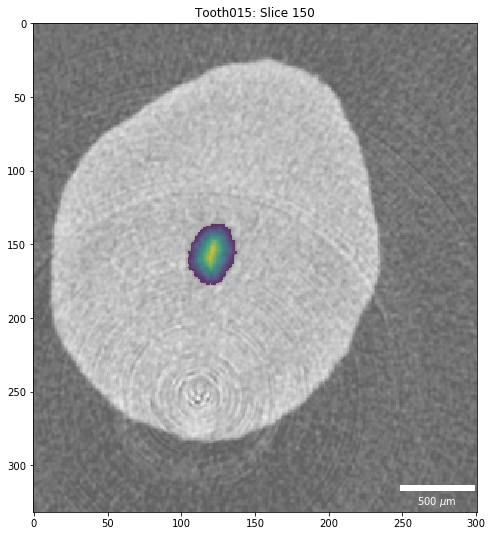

In [100]:
# Select one sample and slice to show what we did in 2D
whichone=3
whichslice=150
plt.imshow(Apexes[whichone][whichslice], alpha=0.618)
plt.imshow(numpy.ma.masked_equal(EDTs[whichone][whichslice], 0), cmap='viridis', alpha=0.618)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
plt.title('%s: Slice %s' % (Data['Sample'][whichone], whichslice))
# plt.axis('off')
plt.savefig('EDT.axial.png',
            bbox_inches='tight')
plt.show()

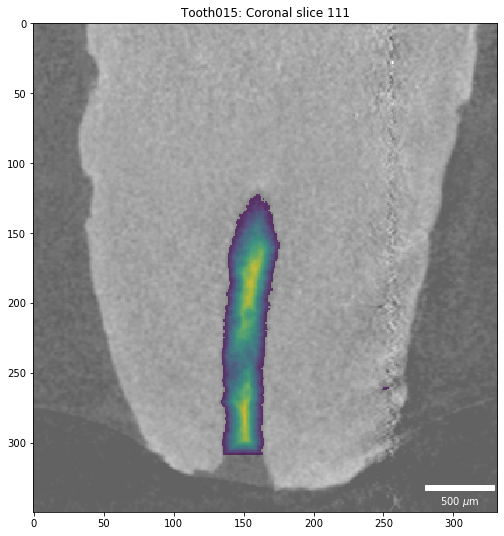

In [101]:
# Show resliced view
where=111
plt.imshow(Apexes[whichone][:,:,where], alpha=0.618)
plt.imshow(numpy.ma.masked_equal(EDTs[whichone][:,:,where], 0), cmap='viridis', alpha=0.618)
plt.savefig('EDT.png',
            bbox_inches='tight')
plt.title(Data['Sample'][whichone])
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichone], 'um'))
plt.title('%s: Coronal slice %s' % (Data['Sample'][whichone], where))
# plt.axis('off')
plt.savefig('EDT.coronal.png',
            bbox_inches='tight')
plt.show()

In [102]:
# Select another sample
whichone = 0
apex = Apexes[whichone]
pulpa = ApexPulpas[whichone]
edt = EDTs[whichone]

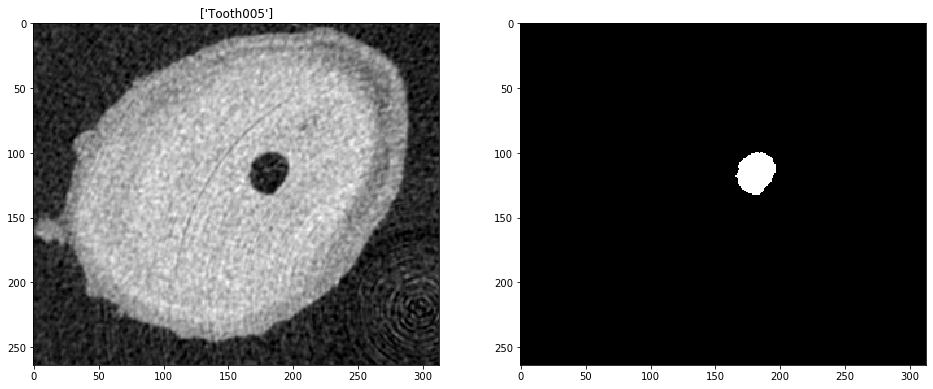

In [103]:
# Show tooth and pulpa
whichslice = 150
plt.subplot(121)
plt.imshow(apex[whichslice])
plt.title([Data['Sample'][whichone]])
plt.subplot(122)
plt.imshow(pulpa[whichslice])
plt.show()

In [104]:
# Calculate Pulpa area (e.g. just sum up each slice, since we have them binarized/segmented)
Data['PulpArea'] = ''
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Calculating pulpa area',
                            total=len(Data)):
    Data.at[c, 'PulpArea'] = [p.sum().compute() for p in ApexPulpas[c]]

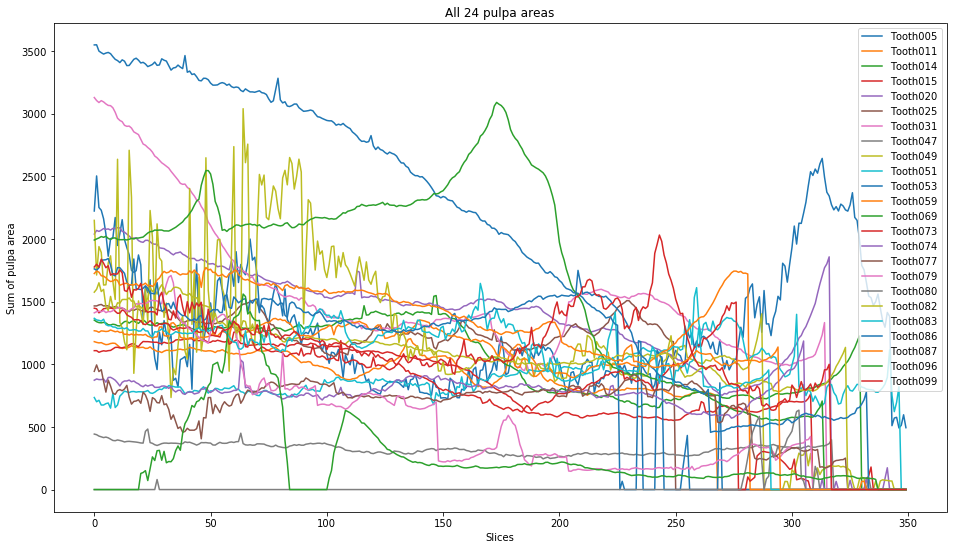

In [105]:
# Show pulpa areas slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving pulpa area plot',
                            total=len(Data)):
    plt.plot(row.PulpArea, label=row.Sample)
plt.xlabel('Slices')
plt.ylabel('Sum of pulpa area')
plt.legend()
plt.title('All %s pulpa areas' % len(Data))
plt.show()

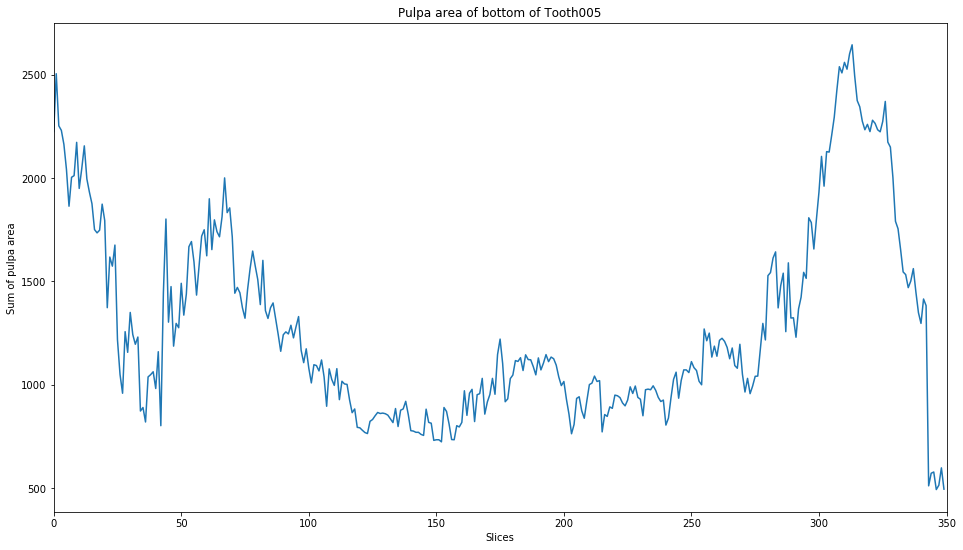

In [106]:
# Save out pulpa areas
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving pulpa area plot',
                            total=len(Data)):
    outfilepath = os.path.join(row['Folder'], row['Sample'] + '.PulpArea.png')
    if not os.path.exists(outfilepath):
        plt.plot(row.PulpArea)
        plt.title('Pulpa area of bottom of %s' % row.Sample)
        plt.xlim([0, row.BottomSlices])
        plt.xlabel('Slices')
        plt.ylabel('Sum of pulpa area')
        plt.savefig(outfilepath, bbox_inches='tight')        
        plt.show()

In [107]:
# Merge Recs and Pulpas
# There's a dask.ma.masked.where* function that we could use, but like so it works just fine.
# The result is the apexes with '0' where we have thresholded the pulpa.
# This makes it possible to merge the EDT into it in a subsequent step.
MergePulpaBlank = [dask.array.multiply(p == False, a) for p, a in zip(ApexPulpas, Apexes)]

In [108]:
# Merge Recs with blanked pulpas and EDT
scaled = False
if scaled:
    # We scale the EDT with the pixel size, so Andrea doesn't have to calculate too much.
    MergePulpaEDT = [dask.array.add(mpb, edt * vs) for mpb, edt, vs in zip(MergePulpaBlank, EDTs, Data.Voxelsize)]
else:
    # We could scale it, but then we clip at 255 (8bit)
    # This is because voxelsize * radius is larger than 255
    # Run the cell below to check.
    MergePulpaEDT = [dask.array.add(mpb, edt) for mpb, edt in zip(MergePulpaBlank, EDTs)]

In [109]:
# print('Tooth, EDT, Voxelsize, EDT * vs')
# for c, i in enumerate(zip(EDTs, Data.Voxelsize)):
#     m = i[0].max().compute()
#     if m * i[1] > 255:
#         print(Data.Sample[c], round(m), i[1], m * i[1])

In [110]:
# for c, row in notebook.tqdm(Data.iterrows()):
#     plt.imshow(MergePulpaEDT[c][222])
#     plt.title(row.Sample)
#     plt.show()               

In [111]:
# Merge and save out rec and pulpa slices
verbose = False
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out merged Rec + EDT slices',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_merge_rec_edt'),
                exist_ok=True)  
    for d, rec in notebook.tqdm(enumerate(MergePulpaEDT[c]),
                                desc=row.Sample,
                                total=len(SkelDists[c]),
                                leave=False):
        filename = os.path.join(row.Folder,
                                'apex_merge_rec_edt', str(row.Sample) + '_rec_merge_edt_%08d.png' % d)
        if not os.path.exists(filename):
            if verbose:
                plt.imshow(rec)
                plt.title('%s, Slice %s' % (row.Sample, d))
                plt.show()
            imageio.imsave(filename, rec.astype('uint8'))

In [112]:
# Reslice the bottom part and write it out
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out Rec + EDT slices, resliced',
                            total=len(Data)):
    os.makedirs(os.path.join(row.Folder, 'apex_merge_rec_edt_reslice'),
                exist_ok=True)
    
    # load the full dataset into memory if empty, otherwise just map it
    if os.listdir(os.path.join(row.Folder,
                               'apex_merge_rec_edt_reslice')):
        mep = MergePulpaEDT[c]
    else:
        mep = MergePulpaEDT[c].compute()
    for d in notebook.tqdm(range(MergePulpaEDT[c].shape[-1]),
                           desc=row.Sample,
                           leave=False):
        filename = os.path.join(row.Folder,
                                'apex_merge_rec_edt_reslice',
                                str(row.Sample) + '_rec_merge_edt_sagittal_%04d.png' % d)
        if not os.path.exists(filename):
            imageio.imsave(filename, mep[:, :, d].astype('uint8'))

In [113]:
TeethPulpa = numpy.maximum(Pulpas[whichone][1:] * 255, Reconstructions[whichone][1:]).astype('uint8')

In [114]:
view(TeethPulpa.astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [115]:
view(Reconstructions[whichone].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [116]:
view(Pulpas[whichone].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…